## Global Wheat Detection with Pytorch
This notebook is made for basic understanding about the dataset and flow of the detection with pytorch.<br>
The reference notebook is [here.](https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train)
* Pytorch starter - FasterRCNN Train
<br>

The goal of this competition [Global Wheat Detection](https://www.kaggle.com/c/global-wheat-detection/overview) is bounding box prediction around each wheat head in images that have them. <br>
If there are no wheat heads, there is no bounding boxes.

### **Files**
* train.csv - the training data
* sample_submission.csv - a sample submission file in the correct format
* train.zip - training images
* test.zip - test images

In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
import re
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import seaborn as sns # plotting

## 1. Data Preprocessing
### Load Data

In [ ]:
path = '../input/global-wheat-detection'
dir_train = os.path.join(path,'train')
train_df=pd.read_csv(os.path.join(path,'train.csv'))
train_df.head()

### **Columns**
* image_id - the unique image ID
* width, height - the width and height of the images
* bbox - a bounding box, formatted as a Python-style list of [xmin, ymin, width, height]
* etc.

From the Data Explorer, the size of train images are same, 1024 x 1024.<br>
To make simple code, bounding box(bbox) is needed to be splited.

In [ ]:
fig, ax = plt.subplots(1)
ax.imshow(plt.imread(os.path.join(path,'train',(train_df['image_id'][3]+'.jpg'))))
xy = [834.0,95.0]
w = 74.0
h = 160.0
rect = patches.Rectangle(xy, w, h, linewidth=2, edgecolor='b', facecolor='none')
ax.add_patch(rect)
plt.show()

### Split Bounding Boxes into X, Y, Width, Height Column

In [ ]:
train_df[['x','y','w','h']] = 0
train_df[['x','y','w','h']]= np.stack(train_df['bbox'].apply(lambda x:np.fromstring(x[1:-1], sep=','))).astype(np.float)

train_df.drop(columns=['bbox','source'], inplace=True)

In [ ]:
train_df['class'] = "wheat_head"
train_df.head()

### Split train data into Train and Validation
To prevent same image going to train and validation dataset, the unique id value is used.

In [ ]:
image_ids = train_df['image_id'].unique()
print("Total number of images = ",len(train_df['image_id']))
print("Number of Unique images = ",len(image_ids))

In [ ]:
split_len = round(len(image_ids)*0.8)

train_ids = image_ids[:split_len]
valid_ids = image_ids[split_len:]

train = train_df[train_df['image_id'].isin(train_ids)]
valid = train_df[train_df['image_id'].isin(valid_ids)]

valid.shape, train.shape

## 2. Data EDA
* Reference Notebook [Global Wheat Detection: Starter EDA](https://www.kaggle.com/kaushal2896/global-wheat-detection-starter-eda)

### Number of images

In [ ]:
print(f'Minumum number of wheat heads: {max(train_df["image_id"].value_counts())}')
print(f'Minimum number of wheat heads: {len(train_df)/train_df["image_id"].nunique()}')

print("Total number of images = ",len(train_df['image_id']))
print(f'Number of Unique images: {len(image_ids)}')
print(f'Total number of images: {len(os.listdir(os.path.join(path, "train")))}')

So there are 3422 images in traing directory and 3373 images are annotated, that means there are 49 images which do not have any wheat heads in it (without annotation)

### Distribution of number of bbox

In [ ]:
sns.displot(train_df['image_id'].value_counts(), kde=False)
plt.xlabel('# of wheat heads')
plt.ylabel('# of images')
plt.title('# of wheat heads vs. # of images')
plt.show()

## 3. Build Dataset

### Options
1. More augmentation
2. MixUp
3. CutMix
4. Cutout -> with <code>albumentations</code>
4. <s>Add new dataset</s>

In [ ]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

In [ ]:
class WheatDataset(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        # dataframe.unique() = 유일한 값 찾기
        # dataframe.value_counts() = 유일한 값 별 갯수 세기
        
    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        # convert imreaded image BGR to RGB
        # opencv2 loads image by BGR order
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        # convert image 0 ~ 255 to 0 ~ 1
        image /= 255.0
        
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2] # x + w
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3] # y + h
        # boxes -> left up corner & right bottom corner
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        
        
        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
            # permute : 모든 차원의 순서를 재배치 0->1, 1->0
            # instead torch.tensor(sample['bboxes'])로 써도 무방

        #return image, target, image_id
        return {
            'image_id': image_id,
            'image':image,
            'boxes':boxes,
            'area':area,
        }

    def __len__(self) -> int:
        #return self.image_ids.shape[0]
        return len(self.image_ids)

In [ ]:
# Code from Data Augmentation Tutorial
class WheatDataset(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        # dataframe.unique() = 유일한 값 찾기
        # dataframe.value_counts() = 유일한 값 별 갯수 세기
         
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, index):
        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        # convert imreaded image BGR to RGB
        # opencv2 loads image by BGR order
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        # convert image 0 ~ 255 to 0 ~ 1
        image /= 255.0
        
        
        ###
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2] # x + w
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3] # y + h
        # boxes -> left up corner & right bottom corner
        
        n_objects = len(records)
        boxes, areas = [], []
        for i in range(n_objects):
            x_min = records.iloc[i]['x']
            x_max = records.iloc[i]['y']
            y_min = records.iloc[i]['x'] + records.iloc[i]['w']
            y_max = records.iloc[i]['y'] + records.iloc[i]['h']
            a_rea = records.iloc[i]['w'] * records.iloc[i]['h']
            boxes.append([x_min, y_min, x_max, y_max])
            areas.append(a_rea)
        

        return {
            'image_id': image_id,
            'image': image,
            'boxes': boxes,
            'area': areas,
        }

<code>iscrowd</code> means the condition of labeling, whether many objects with tiny size are treated as a grouping box or not. In image labeling, object could be hided or enclosed.

### 1. Albumentations - fast image augmentation libarary & Cutout<br>

<code>Albumentations</code> is an image augmentation library. It can substitute <code>torchvision.transforms</code>. Albumentation is much faster and easily replace. 

The detail materials from [albumentations github](https://github.com/albumentations-team/albumentations_examples)

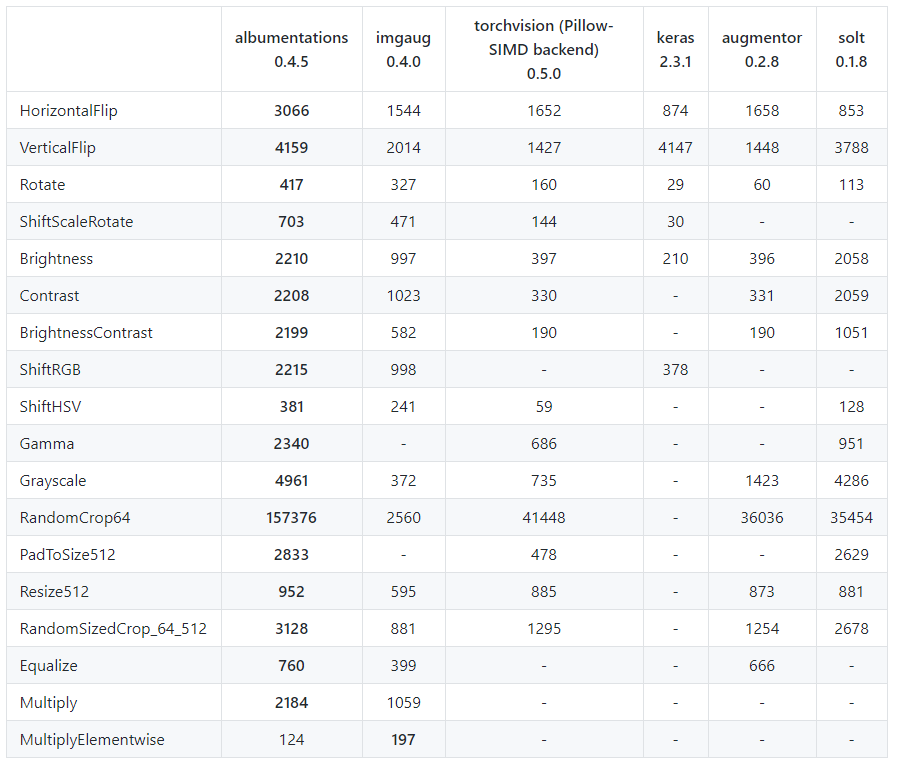

In [ ]:
# Albumentations
# ToTensorV2 : convert image and mask to torch.Tensor
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        A.augmentations.transforms.Cutout(num_holes=3, max_h_size=64, max_w_size=64, fill_value = 0, p=0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        A.Cutout(num_holes=3, max_h_size=32, max_w_size=32, fill_value=0, p=0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

Also <code>Albumentations</code> provides <code>Cutout</code> function.<br>
It can easily adjust directly in your image augmentation.

### 2. MixUp

[Reference: Data Augmentation Tutorial: Basic, Cutout, Mixup](https://www.kaggle.com/kaushal2896/data-augmentation-tutorial-basic-cutout-mixup)

In [ ]:
def mixup(images, bboxes, areas, alpha=1.0):
    """
    Randomly mixes the given list if images with each other
    
    :param images: The images to be mixed up
    :param bboxes: The bounding boxes (labels)
    :param areas: The list of area of all the bboxes
    :param alpha: Required to generate image wieghts (lambda) using beta distribution. In this case we'll use alpha=1, which is same as uniform distribution
    """
    # Generate random indices to shuffle the images
    indices = torch.randperm(len(images))
    shuffled_images = images[indices]
    shuffled_bboxes = bboxes[indices]
    shuffled_areas = areas[indices]
    
    # Generate image weight (minimum 0.4 and maximum 0.6)
    lam = np.clip(np.random.beta(alpha, alpha), 0.4, 0.6)
    print(f'lambda: {lam}')
    
    # Weighted Mixup
    mixedup_images = lam*images + (1 - lam)*shuffled_images
    
    mixedup_bboxes, mixedup_areas = [], []
    for bbox, s_bbox, area, s_area in zip(bboxes, shuffled_bboxes, areas, shuffled_areas):
        mixedup_bboxes.append(bbox + s_bbox)
        mixedup_areas.append(area + s_area)
    
    return mixedup_images, mixedup_bboxes, mixedup_areas, indices.numpy()

In [ ]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [ ]:
#def collate_fn(batch):
#    return tuple(zip(*batch))
def collate_fn(batch):
    images, bboxes, areas, image_ids = ([] for _ in range(4))
    for data in batch:
        images.append(data['image'])
        bboxes.append(data['boxes'])
        areas.append(data['area'])
        image_ids.append(data['image_id'])

    return np.array(images), np.array(bboxes), np.array(areas), np.array(image_ids)
        

#train_dataset = WheatDataset(train, dir_train, get_train_transform())
#valid_dataset = WheatDataset(valid, dir_train, get_valid_transform())
train_dataset = WheatDataset(train, dir_train)
valid_dataset = WheatDataset(valid, dir_train)

# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

If you have any gpu with cuda, make the profram running on GPU, otherwise running on CPU.

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### Check the loaded image

In [ ]:
#images, targets, image_ids = next(iter(train_data_loader))
#images = list(image.to(device) for image in images)
#targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [ ]:
#boxes = targets[2]['boxes'].cpu().numpy().astype(np.float32)
#sample = images[2].permute(1,2,0).cpu().numpy()

In [ ]:
images, bboxes, areas, image_ids = next(iter(train_data_loader))
aug_images, aug_bboxes, aug_areas, aug_indices = mixup(images, bboxes, areas)

In [ ]:
def read_image(image_id, image_dir):
    image = cv2.imread(f'{image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    return image

def get_bbox(bboxes, col, color='white', bbox_format='pascal_voc'):
    for i in range(len(bboxes)):
        if bbox_format == 'pascal_voc':
            rect = patches.Rectangle(
                (bboxes[i][0], bboxes[i][1]),
                bboxes[i][2] - bboxes[i][0], 
                bboxes[i][3] - bboxes[i][1], 
                linewidth=2, 
                edgecolor=color, 
                facecolor='none')
        else:
            rect = patches.Rectangle(
                (bboxes[i][0], bboxes[i][1]),
                bboxes[i][2], 
                bboxes[i][3], 
                linewidth=2, 
                edgecolor=color, 
                facecolor='none')
            
        # Add the patch to the Axes
        col.add_patch(rect)

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(15, 30))
for index in range(5):
    image_id = image_ids[index]
    image = read_image(image_id,dir_train)

    get_bbox(bboxes[index], ax[index][0], color='red')
    ax[index][0].grid(False)
    ax[index][0].set_xticks([])
    ax[index][0].set_yticks([])
    ax[index][0].title.set_text('Original Image #1')
    ax[index][0].imshow(image)
    
    image_id = image_ids[aug_indices[index]]
    image = read_image(image_id,dir_train)
    get_bbox(bboxes[aug_indices[index]], ax[index][1], color='red')
    ax[index][1].grid(False)
    ax[index][1].set_xticks([])
    ax[index][1].set_yticks([])
    ax[index][1].title.set_text('Original Image #2')
    ax[index][1].imshow(image)

    get_bbox(aug_bboxes[index], ax[index][2], color='red')
    ax[index][2].grid(False)
    ax[index][2].set_xticks([])
    ax[index][2].set_yticks([])
    ax[index][2].title.set_text(f'Augmented Image: lambda * image1 + (1 - lambda) * image2')
    ax[index][2].imshow(aug_images[index])
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 30))

sample = read_image(image_ids[2], dir_train)
boxes = get_bbox(bboxes[2], ax, color='red')
#for box in boxes:
#    cv2.rectangle(sample,
#                 (box[0], box[1]),
#                 (box[2], box[3]),
#                 (220, 0, 0), 3)
ax.set_axis_off()
ax.imshow(sample)

## 4. Train model

### Set parameter

* optimizer: SGD<br>
* learning rate: 0.005<br>
* momentum: 0.9<br>
* weight decay: 0.0005<br>
* learning scheduler: No<br>
* number of epochs: 2

### Load Pretrained model on COCO
<code>out_features</code> becomes 2 which is as same as our target.

In [ ]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model

In [ ]:
print(model.roi_heads.box_predictor.cls_score.in_features)
print(model.roi_heads.box_predictor.cls_score)
print(model.roi_heads.box_predictor)

In [ ]:
num_classes = 2 # wheat or not(background)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained model's head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

print(model.roi_heads.box_predictor.cls_score.in_features)
print(model.roi_heads.box_predictor.cls_score)
print(model.roi_heads.box_predictor)

In [ ]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.003, momentum=0.9, weight_decay=0.0005)
lr_scheduler = None

num_epochs = 2

In [ ]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Set loss function
        loss_dict = model(images, targets)
        
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        loss_hist.send(loss_value)
        
        # Set parameters
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        # Display option
        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")
        
        itr += 1
        
    # Learning rate scheduler
    if lr_scheduler is not None:
        lr_scheduler.step()
    
    print(f"Epoch #{epoch} loss: {loss_hist.value}")

In [ ]:
images, targets, image_ids = next(iter(valid_data_loader))

In [ ]:
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

boxes = targets[1]['boxes'].cpu().numpy().astype(np.int32)
sample = images[1].permute(1,2,0).cpu().numpy()

In [ ]:
model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

In [ ]:
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')